<h1 align=left><font size = 5> Coursera Capstone Project</font></h1>

Name: Diane Zhu \
Description: This Notebook will be presenting where to open up a second new cafe for The Cupping Room in Canberra to avoid intense competition and decide new menu

In [86]:
# import modules
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import folium 
import json 
import requests
from sklearn import preprocessing
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize 
from pandas import json_normalize
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler   
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
import warnings
warnings.filterwarnings("ignore")
print('Libraries imported.')

Libraries imported.


In [8]:
CLIENT_ID = 'OZDKUICCB20RTWV25WKNCDIKVFQTY0FXN5VOEQTDYIEZLD4H' # your Foursquare ID
CLIENT_SECRET = 'J3AL4K0P52AKMYYT0NSF0DWKW5CINSSUCFUX0PRWMVGJ4V5D' # your Foursquare Secret
ACCESS_TOKEN = 'B40BODIQ2FYBHQRATF5UYB5RUDQF1FVWB42U1RTDGO0ACECC' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OZDKUICCB20RTWV25WKNCDIKVFQTY0FXN5VOEQTDYIEZLD4H
CLIENT_SECRET:J3AL4K0P52AKMYYT0NSF0DWKW5CINSSUCFUX0PRWMVGJ4V5D


<h3 align=left> The Current Location of The Cupping Room</h3>

In [10]:
address = '13 University Ave, Canberra ACT 2601'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The current location of the franchise cafe is: ',latitude, longitude)

-35.2804909 149.1260595


<h3 align=left> Foursquare Data for Cafe in Canberra</h3>

In [21]:
search_query = 'Cafe'
radius = 500
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()

<h3 align=left> Transform Foursquare JSON into Dataframe</h3>

In [25]:
# assign relevant part of JSON to venues
venues = results['response']['venues']
# tranform venues into a dataframe
dataframe = json_normalize(venues)
display(dataframe.head())
print(dataframe.shape)

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.neighborhood,location.state,location.country,location.formattedAddress,location.city,location.crossStreet
0,58e83848bbec660f966397cb,Mayfair Espresso Cafe,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1627472864,False,40 Marcus Clarke St,-35.278340,149.127180,"[{'label': 'display', 'lat': -35.27834, 'lng':...",260,2601,AU,City,Australian Capital Territory,Australia,"[40 Marcus Clarke St, City ACT 2601]",NaN,NaN
1,4ca5aa5bf47ea1438cee5821,Global Cafe & Bar,"[{'id': '4bf58dd8d48988d10a941735', 'name': 'E...",v-1627472864,False,63 Northbourne Ave,-35.278151,149.128922,"[{'label': 'display', 'lat': -35.2781505741570...",368,2601,AU,City,Australian Capital Territory,Australia,"[63 Northbourne Ave, City ACT 2601]",NaN,NaN
2,5d2572117950f700233f7937,The CMAG Café,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1627472864,False,London Cct,-35.280805,149.130835,"[{'label': 'display', 'lat': -35.2808048335026...",435,2601,AU,City,ACT,Australia,"[London Cct, Canberra ACT 2601]",Canberra,NaN
3,4cb23d76562d224b104b2588,City Edge Cafe,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1627472864,False,50 Marcus Clarke St,-35.277070,149.126725,"[{'label': 'display', 'lat': -35.2770702178689...",385,2601,AU,City,Australian Capital Territory,Australia,"[50 Marcus Clarke St (at Rudd St), Canberra Ci...",NaN,at Rudd St
4,51e883b2498e8f08b9ec8921,Cafe Alibi,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1627472864,False,5 Farrell Pl,-35.281100,149.124690,"[{'label': 'display', 'lat': -35.2811, 'lng': ...",141,2600,AU,City,Australian Capital Territory,Australia,"[5 Farrell Pl, City ACT 2600]",NaN,NaN


(26, 18)


<h3 align=left> Preprocessing Dataframe</h3>

In [27]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
df_cafe = dataframe.loc[:, filtered_columns]
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
# filter the category for each row
df_cafe['categories'] = df_cafe.apply(get_category_type, axis=1)
# clean column names by keeping only last term
df_cafe.columns = [column.split('.')[-1] for column in df_cafe.columns]
df_cafe.head()
# drop unnecessary columns
df_cafe.drop(['labeledLatLngs', 'id'], axis = 1, inplace = True)
display(df_cafe.head())

,name,categories,address,lat,lng,distance,postalCode,cc,neighborhood,state,country,formattedAddress,city,crossStreet
0,Mayfair Espresso Cafe,Café,40 Marcus Clarke St,-35.278340,149.127180,260,2601,AU,City,Australian Capital Territory,Australia,"[40 Marcus Clarke St, City ACT 2601]",NaN,NaN
1,Global Cafe & Bar,Ethiopian Restaurant,63 Northbourne Ave,-35.278151,149.128922,368,2601,AU,City,Australian Capital Territory,Australia,"[63 Northbourne Ave, City ACT 2601]",NaN,NaN
2,The CMAG Café,Café,London Cct,-35.280805,149.130835,435,2601,AU,City,ACT,Australia,"[London Cct, Canberra ACT 2601]",Canberra,NaN
3,City Edge Cafe,Café,50 Marcus Clarke St,-35.277070,149.126725,385,2601,AU,City,Australian Capital Territory,Australia,"[50 Marcus Clarke St (at Rudd St), Canberra Ci...",NaN,at Rudd St
4,Cafe Alibi,Café,5 Farrell Pl,-35.281100,149.124690,141,2600,AU,City,Australian Capital Territory,Australia,"[5 Farrell Pl, City ACT 2600]",NaN,NaN


<h3 align=left> Existing Cafe in Canberra </h3>

In [28]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Conrad Hotel
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='The Cupping Room',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

<h3 align=left> Coffee Order Data Analysis </h3>

In [39]:
# data preprocessing
coffee = pd.read_csv('coffee_order.csv')
# drop irrelevant and redundant columns
coffee.drop(['customer', 'delivery_location'], axis = 1, inplace = True)
coffee = coffee.dropna()
display(coffee)

,drink,category,time,Gender,Age,Annual_Income
0,Latte,Coffee,2019-08-15 07:36:47,Male,19.0,15000.0
1,Flat White,Coffee,2019-08-15 07:36:20,Male,21.0,15000.0
2,Ever Green,Smoothie,2019-08-15 07:33:56,Female,20.0,16000.0
3,Berry Bliss,Smoothie,2019-08-15 07:06:30,Female,23.0,16000.0
4,Chocolate Fix,Smoothie,2019-08-15 06:50:58,Female,31.0,17000.0
...,...,...,...,...,...,...
62,Berry Bliss,Smoothie,2019-07-18 07:14:38,Female,67.0,47000.0
63,Berry Bliss,Smoothie,2019-07-18 07:01:46,Female,54.0,47000.0
64,Berry Bliss,Smoothie,2019-07-18 07:00:34,Male,63.0,48000.0
65,Cappuccino,Coffee,2019-07-18 06:58:55,Male,18.0,48000.0


In [42]:
# encode categorical variables
# gender
le = preprocessing.LabelEncoder()
gender = coffee['Gender']
le.fit(gender)
gender_array = le.transform(gender)
coffee['gender_new'] = gender_array
display(coffee)

,drink,category,time,Gender,Age,Annual_Income,gender_new
0,Latte,Coffee,2019-08-15 07:36:47,Male,19.0,15000.0,1
1,Flat White,Coffee,2019-08-15 07:36:20,Male,21.0,15000.0,1
2,Ever Green,Smoothie,2019-08-15 07:33:56,Female,20.0,16000.0,0
3,Berry Bliss,Smoothie,2019-08-15 07:06:30,Female,23.0,16000.0,0
4,Chocolate Fix,Smoothie,2019-08-15 06:50:58,Female,31.0,17000.0,0
...,...,...,...,...,...,...,...
62,Berry Bliss,Smoothie,2019-07-18 07:14:38,Female,67.0,47000.0,0
63,Berry Bliss,Smoothie,2019-07-18 07:01:46,Female,54.0,47000.0,0
64,Berry Bliss,Smoothie,2019-07-18 07:00:34,Male,63.0,48000.0,1
65,Cappuccino,Coffee,2019-07-18 06:58:55,Male,18.0,48000.0,1


<h3 align=left> Coffee Order Data Visualization </h3>

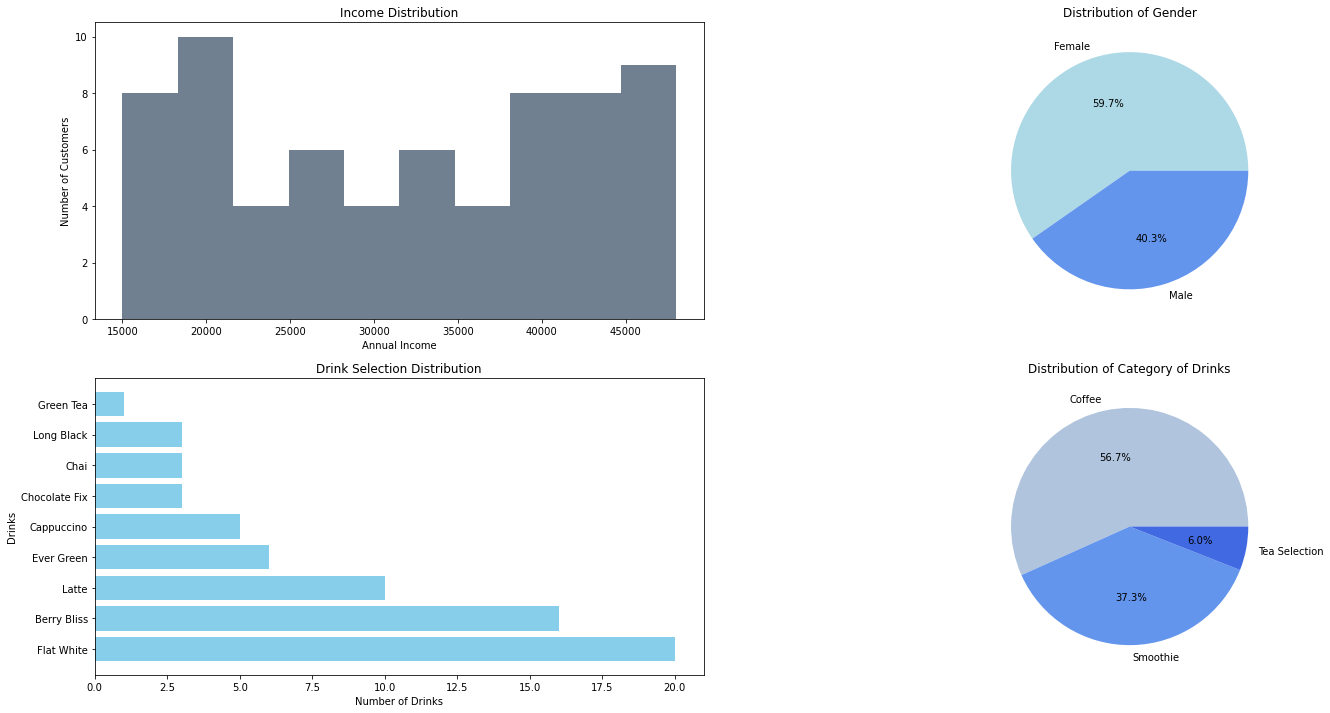

In [35]:
fig = plt.figure(figsize = (24,12))
# salary 
ax1 = plt.subplot(221)
ax1.hist(coffee['Annual_Income'], color = 'slategrey')
ax1.set_title("Income Distribution")
ax1.set_xlabel("Annual Income")
ax1.set_ylabel("Number of Customers")
# gender
ax2 = plt.subplot(222)
genders = coffee['Gender'].value_counts()
gcolors = ["lightblue","cornflowerblue"]
ax2.pie(genders.values, labels = genders.index, colors = gcolors, autopct = '%.1f%%')
ax2.set_title('Distribution of Gender')
# coffee drinks
ax3 = plt.subplot(223)
drinks = coffee['drink'].value_counts()
ax3.barh(drinks.index, drinks.values, color = 'skyblue')
ax3.set_title('Drink Selection Distribution')
ax3.set_xlabel('Number of Drinks')
ax3.set_ylabel('Drinks')
# category
ax4 = plt.subplot(224)
cat = coffee['category'].value_counts()
ccolor = ['lightsteelblue','cornflowerblue','royalblue']
ax4.pie(cat.values, labels = cat.index, colors = ccolor, autopct = '%.1f%%')
ax4.set_title('Distribution of Category of Drinks')
plt.show()

<h3 align=left> KNN Model </h3>

<h4 align=left> Index Encoding </h4>

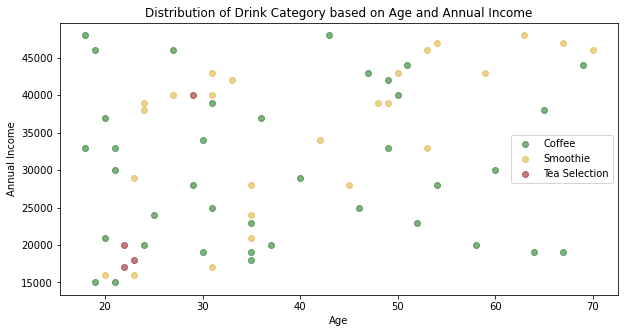

,drink,category,time,Gender,Age,Annual_Income,gender_new,category_index
0,Latte,Coffee,2019-08-15 07:36:47,Male,19.0,15000.0,1,2
1,Flat White,Coffee,2019-08-15 07:36:20,Male,21.0,15000.0,1,2
2,Ever Green,Smoothie,2019-08-15 07:33:56,Female,20.0,16000.0,0,1
3,Berry Bliss,Smoothie,2019-08-15 07:06:30,Female,23.0,16000.0,0,1
4,Chocolate Fix,Smoothie,2019-08-15 06:50:58,Female,31.0,17000.0,0,1
...,...,...,...,...,...,...,...,...
62,Berry Bliss,Smoothie,2019-07-18 07:14:38,Female,67.0,47000.0,0,1
63,Berry Bliss,Smoothie,2019-07-18 07:01:46,Female,54.0,47000.0,0,1
64,Berry Bliss,Smoothie,2019-07-18 07:00:34,Male,63.0,48000.0,1,1
65,Cappuccino,Coffee,2019-07-18 06:58:55,Male,18.0,48000.0,1,2


In [77]:
# create a new column 
def cat_to_index(x):
    if x == 'Tea Selection':
        return 0
    elif x == 'Smoothie':
        return 1
    elif x == 'Coffee':
        return 2
coffee['category_index'] = coffee['category'].apply(cat_to_index)

# classification plot for original data 
cf = coffee[coffee['category'] == 'Coffee']
smt = coffee[coffee['category'] == 'Smoothie']
tea = coffee[coffee['category'] == 'Tea Selection']
plt.figure(figsize=(10,5))
ax1 = plt.subplot(111)
ax1.scatter(cf['Age'], cf['Annual_Income'], c = 'darkgreen', alpha = 0.5, label = 'Coffee')
ax1.scatter(smt['Age'], smt['Annual_Income'], c = 'goldenrod', alpha = 0.5, label = 'Smoothie')
ax1.scatter(tea['Age'], tea['Annual_Income'], c = 'maroon', alpha = 0.5, label = 'Tea Selection')
ax1.legend()
ax1.set_title('Distribution of Drink Category based on Age and Annual Income')
ax1.set_xlabel('Age')
ax1.set_ylabel('Annual Income')
ax1.ticklabel_format(useOffset = False, style='plain')
plt.show()
display(coffee)

<h4 align=left> Determine Number of Neighbors </h4>

In [80]:
# scale predictors  
knndata = coffee[['Age','Annual_Income','gender_new']]
scaler = StandardScaler()
knndata = scaler.fit_transform(knndata)
knndata = pd.DataFrame(data = knndata, columns = ['Age','Annual_Income','gender_new'])

# train test split
features = knndata[['Age','Annual_Income','gender_new']].values
target = coffee['category_index']
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.3)

# determine number of neighbors 
parameters = {"n_neighbors": range(1, 50)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(x_train, y_train)
best_n_neighbors = gridsearch.best_params_['n_neighbors']
print('The best number of neighbors is:',best_n_neighbors)

The best number of neighbors is: 16


<h4 align = left> Fit into KNN Model</h4>

Training score for KNN model is: 0.6304347826086957
Test score for KNN model is: 0.5714285714285714


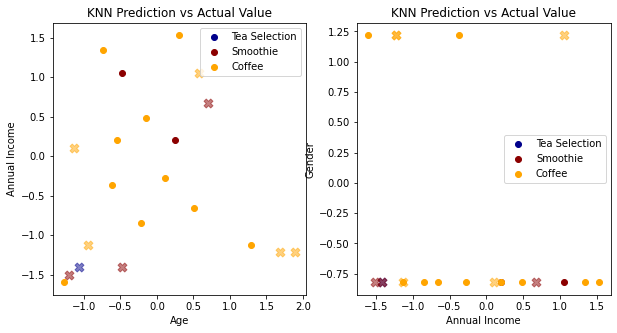

In [83]:
# create knn model 
knn = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print('Training score for KNN model is:', knn.score(x_train, y_train))
print('Test score for KNN model is:', knn.score(x_test, y_test))

# plot knn model using two parameters at a time  
color = ['darkblue', 'darkred', 'orange']
correctly_pred = np.equal(y_pred, y_test)

# index to category
def index_to_cat(x):
    if x == 0:
        return 'Tea Selection'
    elif x == 1:
        return 'Smoothie'
    elif x == 2:
        return 'Coffee'
    
## duration vs bitrate
plt.figure(figsize=(10,5))
ax2 = plt.subplot(121)
for i in range(3):
    correct_index = (y_test == i) & correctly_pred
    ax2.scatter(x_test[correct_index, 0], x_test[correct_index, 1], c = color[i], label = index_to_cat(i))
    correct_index = (y_test == i) & (np.logical_not(correctly_pred))
    ax2.scatter(x_test[correct_index, 0], x_test[correct_index, 1], marker = 'X', s = 80, c = color[i], alpha = 0.5)
ax2.legend()
ax2.set_title('KNN Prediction vs Actual Value')
ax2.set_xlabel('Age')
ax2.set_ylabel('Annual Income')

## i vs p
ax3 = plt.subplot(122)
for i in range(3):
    correct_index = (y_test == i) & correctly_pred
    ax3.scatter(x_test[correct_index, 1], x_test[correct_index, 2], c = color[i], label = index_to_cat(i))
    correct_index = (y_test == i) & (np.logical_not(correctly_pred))
    ax3.scatter(x_test[correct_index, 1], x_test[correct_index, 2], marker = 'X', s = 80,  c = color[i], alpha = 0.5)
ax3.legend()
ax3.set_title('KNN Prediction vs Actual Value')
ax3.set_xlabel('Annual Income')
ax3.set_ylabel('Gender')
plt.show()

<h4 align = left>Model Evaluation</h4>

In [107]:
y_true = y_test.values
teascore, smscore, coscore  =  confusion_matrix(y_true, y_pred, labels = [0, 1, 2])
col1 = teascore[0] + smscore[0] + coscore[0]
col2 = teascore[1] + smscore[1] + coscore[1]
col3 = teascore[2] + smscore[2] + coscore[2]
col4 = col1 + col2 + col3
print('The Confusion Matrix for KNN model is: ')
print("                             PREDICTION")
print("            ____________Tea____Smoothie___Coffee____")
print("                  Tea|  ", teascore[0], "  |   ", teascore[1],"   |  ", teascore[2], "   | ", teascore[0] + teascore[1] + teascore[2])
print("OBSERVATION  Smoothie|  ", smscore[0], "  |   ", smscore[1],"   |  ", smscore[2], "   | ", smscore[0] + smscore[1] + smscore[2])
print("               Coffee|  ", coscore[0], "  |   ", coscore[1],"   |  ", coscore[2], "  | ", coscore[0] + coscore[1] + coscore[2])
print("            ---------------------------------------------")
print("                        ", col1, "      ", col2, "     ",col3, "     ", col4)

The Confusion Matrix for KNN model is: 
                             PREDICTION
            ____________Tea____Smoothie___Coffee____
                  Tea|   0   |    0    |   1    |  1
OBSERVATION  Smoothie|   0   |    2    |   3    |  5
               Coffee|   0   |    5    |   10   |  15
            ---------------------------------------------
                         0        7       14       21


In [88]:
print('Classification Report for KNN Model')
print (classification_report(y_test, y_pred))

Classification Report for KNN Model
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.29      0.40      0.33         5
           2       0.71      0.67      0.69        15

    accuracy                           0.57        21
   macro avg       0.33      0.36      0.34        21
weighted avg       0.58      0.57      0.57        21

